 # Use machine learning methods to  make a model for  identify aggressive tweet
1.Use OLID's tweet training dataset
reference: https://sites.google.com/site/offensevalsharedtask/olid

2.the processing of train text data 

3.the processing of test text data

4.Build model

5.testing model and optimization

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import os

In [2]:
os.chdir(r'D:\dataset\clear_data')

In [3]:
OLID_trainset = pd.read_csv('olid-training-v1.0.csv')
OLID_trainset.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you鈥檙e drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [4]:
OLID_trainset = OLID_trainset[['tweet','subtask_a']]

In [5]:
OLID_trainset = OLID_trainset.rename(columns = {'subtask_a':'label'})

In [6]:
OLID_trainset.head()

,tweet,label
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you鈥檙e drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT


In [7]:
def getscore(score):
    if score == 'OFF':
        return 1
    elif score == 'NOT':
        return 0
    else:
        return np.nan

In [8]:
OLID_trainset.label = OLID_trainset.label.apply(getscore)

In [9]:
OLID_trainset.dropna(subset=['label'],inplace=True)

In [10]:
OLID_trainset.head()

,tweet,label
0,@USER She should ask a few native Americans wh...,1.0
1,@USER @USER Go home you鈥檙e drunk!!! @USER #MAG...,1.0
2,Amazon is investigating Chinese employees who ...,0.0
3,"@USER Someone should'veTaken"" this piece of sh...",1.0
4,@USER @USER Obama wanted liberals &amp; illega...,0.0


# The processing of train text data

In [11]:
# Filter out some useless handles
import re
reg_map = {
    re.compile("rt [@0-9a-z_]{0,10}:"),
    re.compile("[a-zA-z]+://[^\s]*"),
    re.compile('http|htttps…'),
    re.compile('[a-z]*[:.]+\S+'),
    re.compile("@[0-9a-z]+"),
    re.compile("RT[\s]+"),
    re.compile("#"),
    re.compile('https?:\/\/\S+'),
}
def lower_and_remove_with_reg(text: str) -> str:
    text = text.lower()
    for v in reg_map:
        text = v.sub("", text)
    return text

# Filter out some useless handles
OLID_trainset['tweet']=OLID_trainset['tweet'].apply(lower_and_remove_with_reg)
OLID_trainset['tweet'].head()

0     she should ask a few native americans what th...
1      go home you鈥檙e drunk!!!  maga trump2020 馃憡馃嚭...
2    amazon is investigating chinese employees who ...
3     someone should'vetaken" this piece of shit to...
4      obama wanted liberals &amp; illegals to move...
Name: tweet, dtype: object

In [12]:
# replaces periods with Spaces
OLID_trainset['tweet'] =  OLID_trainset['tweet'].str.replace('[^a-zA-Z]', ' ') 

#Delete the short term
OLID_trainset['tweet'] =  OLID_trainset['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [13]:
# Remove stop words
from nltk.corpus import stopwords
stop=stopwords.words('english')
OLID_trainset['tweet'] =  OLID_trainset['tweet'].apply(lambda sen:" ".join(x for x in sen.split() if x not in stop))
OLID_trainset['tweet'].head()

0                                native americans take
1                                home drunk maga trump
2    amazon investigating chinese employees selling...
3                   someone vetaken piece shit volcano
4           obama wanted liberals illegals move states
Name: tweet, dtype: object

In [14]:
#Part of speech reduction
from textblob import Word
OLID_trainset['tweet'] =  OLID_trainset['tweet'].apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))
OLID_trainset['tweet'].head()

0                                 native american take
1                                home drunk maga trump
2    amazon investigating chinese employee selling ...
3                   someone vetaken piece shit volcano
4             obama wanted liberal illegals move state
Name: tweet, dtype: object

In [15]:
#Delete handle
#Participle
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
OLID_trainset['word'] =  OLID_trainset['tweet'].apply(tknzr.tokenize)
OLID_trainset['word'].head()

0                             [native, american, take]
1                           [home, drunk, maga, trump]
2    [amazon, investigating, chinese, employee, sel...
3             [someone, vetaken, piece, shit, volcano]
4      [obama, wanted, liberal, illegals, move, state]
Name: word, dtype: object

In [16]:
# Part-of-speech tagging
from nltk import pos_tag
from nltk import word_tokenize
def get_pos(text):
    token = word_tokenize(text)
    word = (pos_tag(token))
    return word

In [17]:
OLID_trainset['text_tag'] =  OLID_trainset['tweet'].apply(get_pos)
OLID_trainset['text_tag'].head()

0           [(native, JJ), (american, JJ), (take, NN)]
1    [(home, NN), (drunk, NN), (maga, NN), (trump, ...
2    [(amazon, NN), (investigating, VBG), (chinese,...
3    [(someone, NN), (vetaken, VBD), (piece, NN), (...
4    [(obama, RB), (wanted, VBD), (liberal, JJ), (i...
Name: text_tag, dtype: object

In [18]:
OLID_trainset.head()

,tweet,label,word,text_tag
0,native american take,1.0,"[native, american, take]","[(native, JJ), (american, JJ), (take, NN)]"
1,home drunk maga trump,1.0,"[home, drunk, maga, trump]","[(home, NN), (drunk, NN), (maga, NN), (trump, ..."
2,amazon investigating chinese employee selling ...,0.0,"[amazon, investigating, chinese, employee, sel...","[(amazon, NN), (investigating, VBG), (chinese,..."
3,someone vetaken piece shit volcano,1.0,"[someone, vetaken, piece, shit, volcano]","[(someone, NN), (vetaken, VBD), (piece, NN), (..."
4,obama wanted liberal illegals move state,0.0,"[obama, wanted, liberal, illegals, move, state]","[(obama, RB), (wanted, VBD), (liberal, JJ), (i..."


In [19]:
OLID_trainset.word.value_counts()

[]                                                                                                                           335
[fuck]                                                                                                                        23
[liberal]                                                                                                                     15
[good]                                                                                                                        14
[beautiful]                                                                                                                   13
                                                                                                                            ... 
[trump, fucking, asshole, think, otherwise, idiot, friend, hurt, need, educated, educate, everyday, talk, everyday, stfu]      1
[photoshopped]                                                                                   

In [20]:
OLID_trainset = OLID_trainset[OLID_trainset.word.str.len() != 0] 
OLID_trainset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12789 entries, 0 to 13239
Data columns (total 4 columns):
tweet       12789 non-null object
label       12789 non-null float64
word        12789 non-null object
text_tag    12789 non-null object
dtypes: float64(1), object(3)
memory usage: 499.6+ KB


In [21]:
OLID_trainset = OLID_trainset[['tweet','word','text_tag','label']]
OLID_trainset.to_csv('OLID_trainset.csv',index = False)

# The processing of test dataset

In [22]:
os.chdir(r'D:\dataset\clear_data')
OLID_testset = pd.read_csv(r'labels-testset.csv')
OLID_testset.head()

,id,label
0,15923,OFF
1,27014,NOT
2,30530,NOT
3,13876,NOT
4,60133,OFF


In [23]:
def getscore(score):
    if score == 'OFF':
        return 1
    elif score == 'NOT':
        return 0
    else:
        return np.nan

In [24]:
OLID_testset.label = OLID_testset.label.apply(getscore)

In [25]:
OLID_testset.head()

,id,label
0,15923,1
1,27014,0
2,30530,0
3,13876,0
4,60133,1


In [26]:
os.chdir(r'D:\dataset\clear_data')
OLID_test_text = pd.read_csv('testset-levela.csv',usecols=['tweet'])
OLID_test_text.head()

,tweet
0,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,"#ConstitutionDay is revered by Conservatives, ..."
2,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3,#Watching #Boomer getting the news that she is...
4,#NoPasaran: Unity demo to oppose the far-right...


In [27]:
# Filter out some useless handles
import re
reg_map = {
    re.compile("rt [@0-9a-z_]{0,10}:"),
    re.compile("[a-zA-z]+://[^\s]*"),
    re.compile('http|htttps…'),
    re.compile('[a-z]*[:.]+\S+'),
    re.compile("@[0-9a-z]+"),
     re.compile("#[0-9a-z]+"),
    re.compile("RT[\s]+"),
    re.compile('https?:\/\/\S+'),
}
def lower_and_remove_with_reg(text: str) -> str:
    text = text.lower()
    for v in reg_map:
        text = v.sub("", text)
    return text

# Filter out some useless handles
OLID_test_text['tweet']=OLID_test_text['tweet'].apply(lower_and_remove_with_reg)
OLID_test_text['tweet'].head()

0        democrats support antifa, muslim brotherho...
1     is revered by conservatives, hated by progres...
2                                first, it reduces ...
3      getting the news that she is still up for pa...
4    : unity demo to oppose the far-right in  鈥?  鈥...
Name: tweet, dtype: object

In [28]:
# replaces periods with Spaces
OLID_test_text['tweet'] =  OLID_test_text['tweet'].str.replace('[^a-zA-Z]', ' ') 

#Delete the short term
OLID_test_text['tweet'] =  OLID_test_text['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [29]:
# Remove stop words
from nltk.corpus import stopwords
stop=stopwords.words('english')
OLID_test_text['tweet'] =  OLID_test_text['tweet'].apply(lambda sen:" ".join(x for x in sen.split() if x not in stop))
OLID_test_text['tweet'].head()

0    democrats support antifa muslim brotherhood is...
1    revered conservatives hated progressives socia...
2                                        first reduces
3    getting news still parole always makes smile t...
4                unity demo oppose right enough enough
Name: tweet, dtype: object

In [30]:
#Part of speech reduction
from textblob import Word
OLID_test_text['tweet'] =  OLID_test_text['tweet'].apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))
OLID_test_text['tweet'].head()

0    democrat support antifa muslim brotherhood isi...
1    revered conservative hated progressive sociali...
2                                        first reduces
3    getting news still parole always make smile tr...
4                unity demo oppose right enough enough
Name: tweet, dtype: object

In [31]:
#Delete handle
#Participle
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
OLID_test_text['word'] =  OLID_test_text['tweet'].apply(tknzr.tokenize)
OLID_test_text['word'].head()

0    [democrat, support, antifa, muslim, brotherhoo...
1    [revered, conservative, hated, progressive, so...
2                                     [first, reduces]
3    [getting, news, still, parole, always, make, s...
4         [unity, demo, oppose, right, enough, enough]
Name: word, dtype: object

In [32]:
# Part-of-speech tagging
from nltk import pos_tag
from nltk import word_tokenize
def get_pos(text):
    token = word_tokenize(text)
    word = (pos_tag(token))
    return word

In [33]:
OLID_test_text['text_tag'] =  OLID_test_text['tweet'].apply(get_pos)
OLID_test_text['text_tag'].head()

0    [(democrat, JJ), (support, NN), (antifa, NN), ...
1    [(revered, VBN), (conservative, JJ), (hated, V...
2                        [(first, RB), (reduces, NNS)]
3    [(getting, VBG), (news, NN), (still, RB), (par...
4    [(unity, NN), (demo, NN), (oppose, RB), (right...
Name: text_tag, dtype: object

In [34]:
OLID_testset = pd.concat([OLID_testset,OLID_test_text],axis = 1)
OLID_testset.head()

,id,label,tweet,word,text_tag
0,15923,1,democrat support antifa muslim brotherhood isi...,"[democrat, support, antifa, muslim, brotherhoo...","[(democrat, JJ), (support, NN), (antifa, NN), ..."
1,27014,0,revered conservative hated progressive sociali...,"[revered, conservative, hated, progressive, so...","[(revered, VBN), (conservative, JJ), (hated, V..."
2,30530,0,first reduces,"[first, reduces]","[(first, RB), (reduces, NNS)]"
3,13876,0,getting news still parole always make smile tr...,"[getting, news, still, parole, always, make, s...","[(getting, VBG), (news, NN), (still, RB), (par..."
4,60133,1,unity demo oppose right enough enough,"[unity, demo, oppose, right, enough, enough]","[(unity, NN), (demo, NN), (oppose, RB), (right..."


In [35]:
OLID_testset = OLID_testset[['tweet','word','text_tag','label']]
OLID_testset.to_csv('OLID_testset.csv',index = False)

# Build a machine learning model
1. Use bag-of-words model and TF-IDF respectively for text feature representation. The max_features parameter refers to the maximum value of the selected feature number, which is determined according to the data situation and needs

2. Randomly divide the data set and training set

3. Import algorithm model

4. Training algorithm model

5. Predict the text sentiment in the test set

6. Assess the effect of classification

7. Save the trained algorithm model

In [36]:
os.chdir(r'D:\dataset\clear_data')

OLID_trainset = pd.read_csv('OLID_trainset.csv')
OLID_trainset.head()

,tweet,word,text_tag,label
0,native american take,"['native', 'american', 'take']","[('native', 'JJ'), ('american', 'JJ'), ('take'...",1.0
1,home drunk maga trump,"['home', 'drunk', 'maga', 'trump']","[('home', 'NN'), ('drunk', 'NN'), ('maga', 'NN...",1.0
2,amazon investigating chinese employee selling ...,"['amazon', 'investigating', 'chinese', 'employ...","[('amazon', 'NN'), ('investigating', 'VBG'), (...",0.0
3,someone vetaken piece shit volcano,"['someone', 'vetaken', 'piece', 'shit', 'volca...","[('someone', 'NN'), ('vetaken', 'VBD'), ('piec...",1.0
4,obama wanted liberal illegals move state,"['obama', 'wanted', 'liberal', 'illegals', 'mo...","[('obama', 'RB'), ('wanted', 'VBD'), ('liberal...",0.0


In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline


# from sklearn.model_selection import GridSearchCV

# Random Forest Classifier 
Rf = RandomForestClassifier()

# SVM Classifier 
Svm = SGDClassifier()

# Naive Bayes 
Nb = MultinomialNB()

#Confirm training data set
x_train=OLID_trainset['text_tag'] #Independent variable
y_train=OLID_trainset['label']  #Dependent variable

In [38]:
#Word bag model
bow_vectorizer = CountVectorizer(max_df=0.6, min_df=1, max_features=1000)

# TF-IDF feature
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, min_df=1, max_features=1000)

#Use model
Svm_pipe = make_pipeline(tfidf_vectorizer,Svm)
Svm_pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.7, max_features=1000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
           

# Naive Bayes parameter tuning

In [431]:
#Word bag model
bow_vectorizer = CountVectorizer(max_df=0.6, min_df=1, max_features=1000)

# TF-IDF feature
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, min_df=1, max_features=1000)

#Use model
Nb_pipe = make_pipeline(bow_vectorizer,Nb)
Nb_pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.6,
                                 max_features=1000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

# Randoom forest parameter tuning

In [432]:
#Word bag model
bow_vectorizer = CountVectorizer(max_df=0.5, min_df=1, max_features=1000,ngram_range=(1, 2))

# TF-IDF feature
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=1, max_features=1000)

#Use model
Rf_pipe = make_pipeline(tfidf_vectorizer,Rf)
Rf_pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.6, max_features=1000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [415]:
# #使用词袋模型
# pipe = make_pipeline(bow_vectorizer,Rf)
# pipe.fit(x_train, y_train)

In [416]:
# Nb_param_grid = {randomforest__ : ['','']}
# TF-IDF feature
# pipe = make_pipeline(tfidf_vectorizer,Nb)
# grid_search = GridSearchCV(pipe, Nb_param_grid, cv=5)
# grid_search.fit(x_train, y_train)

In [417]:
# #查看带有交叉验证的网格搜索，模型选择的最佳参数，以及测试数据集上的评价指标准确率
# print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
# print("Best parameters: {}".format(grid.best_params_))
# print("Test set score: {:.2f}".format(grid.score(x_test, y_test)))

# Import test data set for testing and optimization

In [418]:
os.chdir(r'D:\dataset\clear_data')

OLID_testset = pd.read_csv('OLID_testset.csv')
OLID_testset.head()

,tweet,word,text_tag,label
0,democrat support antifa muslim brotherhood isi...,"['democrat', 'support', 'antifa', 'muslim', 'b...","[('democrat', 'JJ'), ('support', 'NN'), ('anti...",1
1,revered conservative hated progressive sociali...,"['revered', 'conservative', 'hated', 'progress...","[('revered', 'VBN'), ('conservative', 'JJ'), (...",0
2,first reduces,"['first', 'reduces']","[('first', 'RB'), ('reduces', 'NNS')]",0
3,getting news still parole always make smile tr...,"['getting', 'news', 'still', 'parole', 'always...","[('getting', 'VBG'), ('news', 'NN'), ('still',...",0
4,unity demo oppose right enough enough,"['unity', 'demo', 'oppose', 'right', 'enough',...","[('unity', 'NN'), ('demo', 'NN'), ('oppose', '...",1


In [433]:
x_test=OLID_testset['word']
y_test=OLID_testset['label']

#Make predictions
y_pred = Rf_pipe.predict(x_test) 
#Save the prediction results to the dataframe
df = pd.DataFrame(x_test) 
df['y_test']=y_test
df['pred']=y_pred
label = [0,1]

In [434]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,labels=label))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       620
           1       0.72      0.45      0.55       240

    accuracy                           0.80       860
   macro avg       0.77      0.69      0.71       860
weighted avg       0.79      0.80      0.78       860



In [435]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.6898521505376344

[[579  41]
 [133 107]]


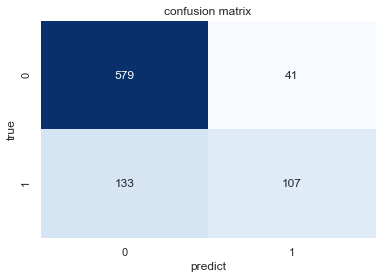

In [436]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set()
f,ax=plt.subplots()
C2= confusion_matrix(y_test, y_pred, labels=[0, 1])
print(C2) 

#Heat map
sns.heatmap(C2,annot=True,ax=ax,cbar = None, cmap = 'Blues', fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('confusion matrix')
ax.set_xlabel('predict')
ax.set_ylabel('true')
plt.show()

In [437]:
from sklearn.externals import joblib
# Save to sklearn's own file format
joblib.dump(Rf_pipe, 'Rf_pipe.pkl')

['Rf_pipe.pkl']